In [3]:
import sys
sys.path.append('../astro_tools')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from tqdm import tqdm
from astropy.wcs import wcs
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import ImageGrid
from reproject import reproject_interp
from astropy import units as u
from matplotlib.lines import Line2D
from astropy.visualization.wcsaxes import add_beam, add_scalebar

# set up the plot
plt.rcParams['text.usetex'] = False
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.5
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams["font.family"] = "courier new"
plt.rcParams["font.style"] = "normal"
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.weight"] = 'bold'

import warnings
warnings.filterwarnings('ignore')

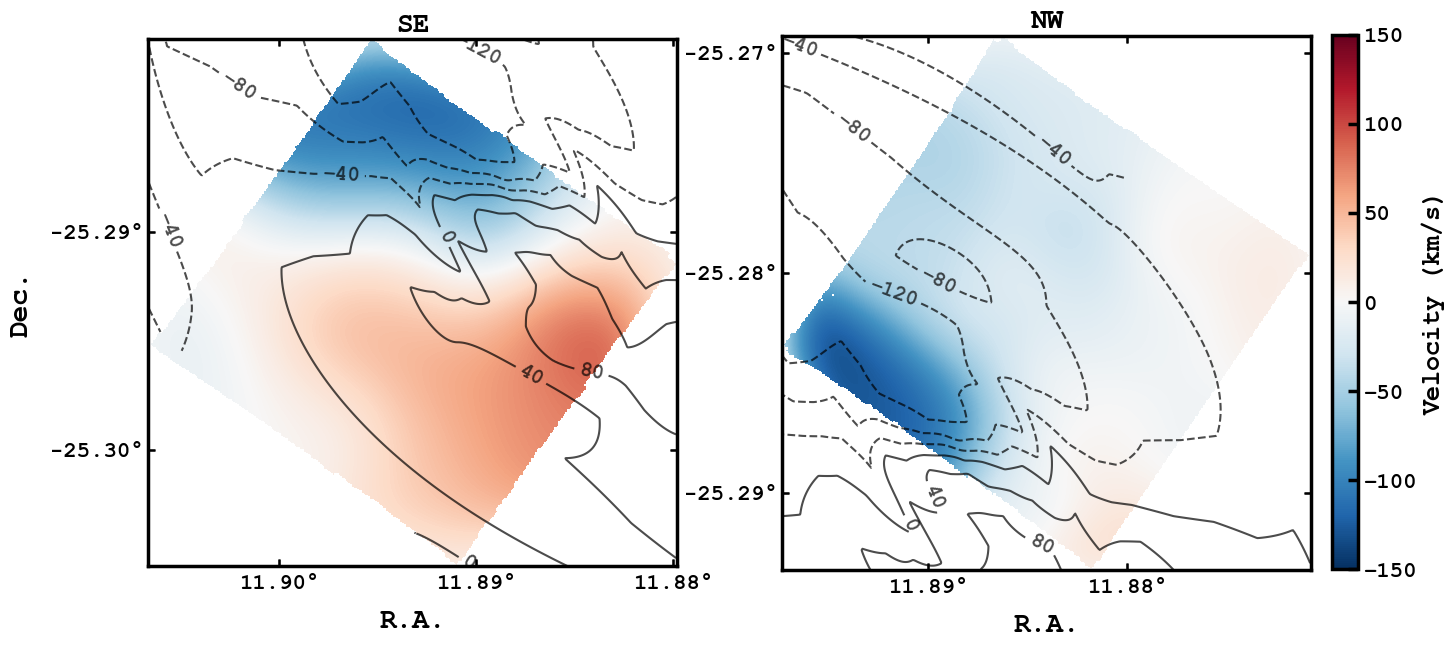

In [4]:
# read in the data cubes
south_cube = fits.open('../ngc253/data/ADP.2018-11-22T21_29_46.157.fits')
north_cube = fits.open('../ngc253/data/ADP.2019-08-24T09_53_08.548.fits')
CO_cube = fits.open('../ngc253/data/NGC253.CO_1-0.diskfit.total_model_NKrieger.fits')

# we want the CO cube to just have 2 axes (RA and Dec)
w = wcs.WCS(CO_cube[0].header, naxis=2).celestial
CO_cube_new = fits.PrimaryHDU(data=CO_cube[0].data, header=w.to_header())

# ============================================
# NORTH
# ============================================

# we also want our cube to just have 2 axes (RA and Dec)
w_north = wcs.WCS(north_cube[1].header, naxis=2).celestial
north_cube_header = w_north.to_header()
z_north, y_north, x_north = north_cube[1].shape

# now open the CO cube and reproject it into the footprint
# of our cube using the wcs information
CO_cube_array_north, footprint_north = reproject_interp(CO_cube_new, north_cube_header, shape_out=(y_north,x_north))

# convert from LSRK to Barycentric frame to match our data
# https://docs.astropy.org/en/stable/api/astropy.coordinates.LSRK.html
CO_cube_array_north = CO_cube_array_north - 20  # km/s

# subtract the systemic velocity
CO_cube_array_north = CO_cube_array_north - 243  # km/s


# ============================================
# SOUTH
# ============================================

# we also want our cube to just have 2 axes (RA and Dec)
w_south = wcs.WCS(south_cube[1].header, naxis=2).celestial
south_cube_header = w_south.to_header()
z_south, y_south, x_south = south_cube[1].shape

# now open the CO cube and reproject it into the footprint
# of our cube using the wcs information
CO_cube_array_south, footprint_south = reproject_interp(CO_cube_new, south_cube_header, shape_out=(y_south,x_south))

# convert from LSRK to Barycentric frame to match our data
# https://docs.astropy.org/en/stable/api/astropy.coordinates.LSRK.html
CO_cube_array_south = CO_cube_array_south - 20  # km/s

# subtract the systemic velocity
CO_cube_array_south = CO_cube_array_south - 243  # km/s

# ============================================
# PLOT
# ============================================

fig = plt.figure(figsize=(15,7))

# read in our H-alpha velocity models
Halpha_cube_north = fits.open('../ngc253/data/ngc253_nw_halpha_vel_model_smooth.fits')
Halpha_cube_array_north = Halpha_cube_north[0].data
Halpha_cube_south = fits.open('../ngc253/data/ngc253_se_halpha_vel_model_smooth_FINAL.fits')
Halpha_cube_array_south = Halpha_cube_south[0].data

# plot the SE model
ax = plt.subplot(1, 2, 1, projection=w_south)
im = ax.imshow(Halpha_cube_array_south, origin='lower', vmin=-150, vmax=150, cmap='RdBu_r')
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5)
ax.set_xlabel('R.A.', fontsize=20)
ax.set_ylabel('Dec.', fontsize=20)
ax.coords[0].set_major_formatter('d.dd')
ax.coords[1].set_major_formatter('d.dd')
ax.set_title('SE',fontsize=20)

contours_south = ax.contour(CO_cube_array_south, 6, colors='k', alpha=0.7)
ax.clabel(contours_south, fontsize=15, inline=True)

# plot the NW model
ax = plt.subplot(1, 2, 2, projection=w_north)
im = ax.imshow(Halpha_cube_array_north, origin='lower', vmin=-150, vmax=150, cmap='RdBu_r')
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5)
ax.set_xlabel('R.A.', fontsize=20)
ax.coords[0].set_major_formatter('d.dd')
ax.coords[1].set_major_formatter('d.dd')
ax.coords[1].set_auto_axislabel(False)
ax.set_title('NW',fontsize=20)

contours_north = ax.contour(CO_cube_array_north, 6, colors='black', alpha=0.7)
ax.clabel(contours_north, fontsize=15, inline=True)

# add a color bar
cax = ax.inset_axes([1.04, 0.002, 0.05, 1])  # make another axis for the colorbar 
                                             # [x0, y0, width, height] where x0, y0 = lower left corner
bar = fig.colorbar(im, ax=ax, cax=cax)
bar.set_label('Velocity (km/s)', fontsize=18)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

plt.savefig('../ngc253/visuals/velocity_models.png', dpi=200)
plt.show()

In [5]:
# read in the data cubes
from spectral_cube import SpectralCube
from astropy.nddata.utils import Cutout2D

# south_cube = fits.open('../ngc253/data/ADP.2018-11-22T21_29_46.157.fits')
north_cube = fits.open('../ngc253/data/ADP.2019-08-24T09_53_08.548.fits')
IR_cube = fits.open('../ngc253/data/NGC_0253_I_IRAC_8.0_d2009.fits')

x0 = 1800
x1 = 2450
y0 = 2000
y1 = 2650
center = ((x1 + x0)/2, (y1 + y0)/2)
new_shape = (y1-y0, x1-x0)
IR_cube_cutout = Cutout2D(IR_cube[0].data, center, size=new_shape, wcs=wcs.WCS(IR_cube[0].header))

south_cube = SpectralCube.read('../ngc253/data/ADP.2018-11-22T21_29_46.157.fits', hdu=1)
south_cube_wcs = south_cube[0,:,:].wcs
south_cube_mom0 = south_cube[1800,:,:].to_value()  # moment 0
nan_mask_south = np.isfinite(south_cube_mom0).astype(float)  # boolean array

north_cube = SpectralCube.read('../ngc253/data/ADP.2019-08-24T09_53_08.548.fits', hdu=1)
north_cube_wcs = north_cube[0,:,:].wcs
north_cube_mom0 = north_cube[1800,:,:].to_value()  # moment 0
nan_mask_north = np.isfinite(north_cube_mom0).astype(float)  # boolean array

nan_mask_reproj_south, footprint = reproject_interp((nan_mask_south, south_cube_wcs), IR_cube_cutout.wcs, shape_out=new_shape)
nan_mask_reproj_north, footprint = reproject_interp((nan_mask_north, north_cube_wcs), IR_cube_cutout.wcs, shape_out=new_shape)

In [23]:
Afont = {
        'family' : 'courier new',
        'weight': 'bold',
        'size': 14,
        }

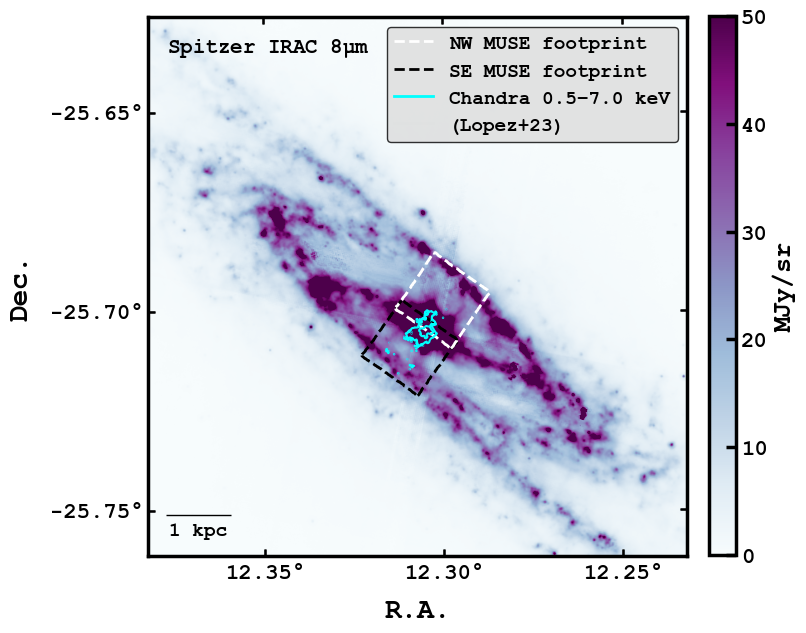

In [22]:
fig = plt.figure(figsize=(9,7))
ax = plt.subplot(1,1,1, projection=wcs.WCS(IR_cube[0].header))
im = ax.imshow(IR_cube_cutout.data, vmin=0, vmax=50, cmap='BuPu')
ax.contour(nan_mask_reproj_south, levels=[0.5], lws=0.5, colors='black', linewidths=2, linestyles='--', labels='SE')
ax.contour(nan_mask_reproj_north, levels=[0.5], lws=0.5, colors='white', linewidths=2, linestyles='--', labels='NW')

ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5, color='black')
ax.set_xlabel('R.A.', fontsize=20)
ax.set_ylabel('Dec.', fontsize=20)
ax.coords[0].set_major_formatter('d.dd')
ax.coords[1].set_major_formatter('d.dd')

# add a color bar
cax = ax.inset_axes([1.04, 0.002, 0.05, 1])  # make another axis for the colorbar 
                                             # [x0, y0, width, height] where x0, y0 = lower left corner
bar = fig.colorbar(im, ax=ax, cax=cax)
bar.set_label('MJy/sr', fontsize=18)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

at = AnchoredText('Spitzer IRAC 8$\mu$m', prop=dict(size=15), frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

Xray = fits.open('../ngc253/data/ngc253_chandra_diffuse.fits')
Xray_array, _ = reproject_interp(Xray, IR_cube_cutout.wcs, shape_out=new_shape)
Xray_cont = ax.contour(Xray_array, levels=[9, 55, 311], colors='cyan')

# CO_out = SpectralCube.read('../ngc253/data/ngc253_co_comb_mopra_clean_pbcor_RO.fits', hdu=1)
# CO_out_wcs = CO_out[0,:,:].wcs
# CO_mom0 = CO_out.moment(order=0)  # moment 0
# CO_out_array, _ = reproject_interp((CO_mom0, w_CO), IR_cube_cutout.wcs, shape_out=new_shape)

# CO_cont = ax.contour(CO_out_array, levels=[0, 100, 300], colors='lime', alpha=0.3)

# CO_out = fits.open('../ngc253/data/ngc253_co_comb_mopra_clean_pbcor_RO.fits')
# w_CO = wcs.WCS(CO_out[0].header, naxis=2).celestial
# CO_out_array, _ = reproject_interp((CO_out[0].data[74,:,:], w_CO), IR_cube_cutout.wcs, shape_out=new_shape)
# CO_cont = ax.contour(CO_out_array, levels=[0.424021, 3.7791], colors='lime')

distance = 3.5 * u.Mpc
scalebar_length = 1 * u.kpc
scalebar_angle = (scalebar_length / distance).to(u.deg, equivalencies=u.dimensionless_angles())

# Add a scale bar
add_scalebar(ax, scalebar_angle, label="1 kpc", fontproperties=Afont, corner='bottom left')

custom_lines = [Line2D([0], [0], color='white', lw=2, ls='--'),
                Line2D([0], [0], color='black', lw=2, ls='--'),
                Line2D([0], [0], color='cyan', lw=2, ls='-'),
                Line2D([0], [0], color='gainsboro', alpha=0.1,lw=2, ls='-')]
    
plt.legend(custom_lines,['NW MUSE footprint', 'SE MUSE footprint', 'Chandra 0.5–7.0 keV', '(Lopez+23)'], fontsize=14, 
                        loc='upper right', facecolor='gainsboro', edgecolor='black')

# plt.tight_layout()
plt.savefig('../ngc253/visuals/footprints.png', dpi=200)

plt.show()